## Import libraries

In [1]:
!pip3 install youtube-transcript-api

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [3]:
from youtube_transcript_api import YouTubeTranscriptApi
from transformers import pipeline
import pickle
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
import sklearn
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
import scikitplot as skplt


## Get captions from videos

In [8]:
video_list = ['kpCEeBY5TWY', 'w9M7pg5dkeg', 'aw6E-UidcYw', 't44kc6dRNY0', 'mkRIoCtRynY' ]
language_list = ['fr', 'fr', 'fr', 'fr', 'fr']
video_trans = ""

In [9]:
for idx, video_name in enumerate(video_list):
    srt = YouTubeTranscriptApi.get_transcript(video_name, languages=[language_list[idx]])
    for i in range(len(srt)):
        s = srt[i]['text'] + ' '
        video_trans += s


## Translate captions

In [10]:
model_checkpoint = "Helsinki-NLP/opus-mt-fr-en"
translator = pipeline("translation", model=model_checkpoint)


In [11]:
video_trans_split =  video_trans.split(' ')

In [12]:
n_words = len(video_trans_split)
batch_size = 200
trans_text = []
n_batches = n_words//batch_size
for i in range(n_batches):
    batch_text = ' '.join(video_trans_split[i*batch_size: (i+1)*batch_size])
    trans_text.append(translator(batch_text)[0]['translation_text'])

In [13]:
trans_text.append(translator(' '.join(video_trans_split[(n_batches * batch_size):]))[0]['translation_text'])

In [14]:
trans_text

['Ladies and gentlemen, the Liberal Green delegation welcomes this message and we shall come to this point every project will follow the Federal Council in broad terms. We welcome in particular the actions on the housing stock with regard to the reduction of CO2 emissions which are gratifying that the departments are doing their utmost to maintain and strengthen environmental measures, and we welcome the fact that the army is making an essential contribution to it with regard to the attempt by a minority of the Finance Committee to impose higher standards. It is obviously commendable, but we must keep it on the ground that we must do everything we can to the reasonable extent, we trust in those who are in charge of the execution to ensure that the spirit of doing the most reasonably is present is firmly applied. We call on the minority to reject the proposed weapons programme in response to the hybrid threats that are identified to extend the pipeline network and equip the senses of ca

## Create context vector

In [15]:
context_vector = ' '.join(trans_text)

In [16]:
with open('topics.pickle', 'rb') as handle:
    topics_to_keyword = pickle.load(handle)

In [17]:
d = {'video_number': [1], 'context': [context_vector]}
df = pd.DataFrame(data=d)

In [18]:
classes = [set() for _ in range(len(df))]

for i, context in enumerate(df["context"]):
    for topic in topics_to_keyword:
        for keyword in topics_to_keyword[topic]:
            if keyword in context:
                classes[i].add(topic)
        

In [19]:
df['topic'] = classes

In [20]:
df

,video_number,context,topic
0,1,"Ladies and gentlemen, the Liberal Green delega...","{ecology, external_relations, family, health, ..."


## Import df questions

In [21]:
df_questions = pd.read_csv('./csv/pointet_questions.csv', sep=';', encoding='latin-1')

In [22]:
#convert to binary
df_questions["questions"] = df_questions['questions'].str[4:-2]
df_questions.loc[df_questions['smartvote_answers'] >= 3, 'binary_smarvote_answer'] = 0
df_questions.loc[df_questions['smartvote_answers'] <= 2, 'binary_smarvote_answer'] = 1

In [23]:
topics =  list(topics_to_keyword.keys())

In [24]:
videos_with_topic = defaultdict(list)

In [25]:
for i in range(len(df)):
    if df.iloc[i]['topic']:
        for topic in df.iloc[i]['topic']:
            videos_with_topic[topic].append(df.iloc[i]['context'])
        

In [26]:
context_videos = {}        

In [27]:
#join context vidoes
for topic in topics:
    context_videos[topic] = ''.join(videos_with_topic[topic])

In [28]:
qa_model = pipeline("question-answering", model = "deepset/roberta-base-squad2")

In [29]:
# THIS IS ONLY VALID FOR ONE VIDEO, NEED TO CHANGE CODE for MULTIPLE VIDEOS!!!!!!!

huggingface_answers = []
for i in tqdm(range(len(df_questions))):
    question = df_questions.iloc[i]['Simplified question']
    topic = df_questions.iloc[i]['Topic']
    context = df['context'][0]        
    huggingface_answers.append(qa_model(question = question, context = context))

100%|██████████| 60/60 [01:50<00:00,  1.84s/it]


In [30]:
df_questions["huggingface_answers"] = huggingface_answers

In [31]:
df_questions.to_csv("./csv//video_answers_pointet.csv")

In [32]:
df_questions_videos = pd.read_csv('./csv/video_answers_pointet_label.csv', sep = ';', engine='python')

In [33]:
df_questions_videos

,Column1,questions,smartvote_answers,Simplified question,Unnamed: 3,Topic,Keywords,binary_smarvote_answer,huggingface_answers,cami_answer
0,0,tes-vous favorable à une hausse de l'âge de la...,1,''Are you in favour of raising the retirement ...,NaN,Family,pension; AHV; AVS,1,"{'score': 0.37359175086021423, 'start': 5570, ...",2
1,1,'État devrait-il renforcer son soutien financi...,3,''Should the state support childcare? '',NaN,Family,benefit; childcare; nursery,0,"{'score': 0.07512129098176956, 'start': 6856, ...",1
2,2,ne initiative demande l'instauration d'un cong...,1,''Are you in favour of a paternity leave?'',NaN,Family,paternity; leave,1,"{'score': 0.24946582317352295, 'start': 5570, ...",2
3,3,es rentes de la caisse de pension doivent-elle...,1,''Should the finance state pension funds?'',NaN,Family,pension; life expectancy,1,"{'score': 0.18796247243881226, 'start': 8180, ...",2
4,4,outenez-vous les efforts au niveau des cantons...,3,''Are you in favor of benefits?'',NaN,Family,benefits; social assistance,0,"{'score': 0.17169030010700226, 'start': 5570, ...",2
5,5,a Confédération devrait-elle encourager davant...,3,''Are you in favor of public housing?'',NaN,Family,social housing; construction; public housing,0,"{'score': 0.43310239911079407, 'start': 5570, ...",2
6,6,es personnes assurées devraient-elles contribu...,2,''Should the health insurance cost more'',NaN,Health,health cost; health care cost; premium,1,"{'score': 0.210253044962883, 'start': 6170, 'e...",2
7,7,pprouveriez-vous le principe du consentement p...,2,''Is organ donation good?'',NaN,Health,organ; donation,1,"{'score': 0.08147784322500229, 'start': 2671, ...",1
8,8,"ne vaccination obligatoire des enfants, basée ...",2,''Should vaccines be compulsory? '',NaN,Health,vaccine; vaccination,1,"{'score': 0.024572717025876045, 'start': 8616,...",2
9,9,ne initiative demande que les subsides aux ass...,4,''Should health be proportional to your income?'',NaN,Health,insurance; premium; subsidies,0,"{'score': 0.08890785276889801, 'start': 7816, ...",2


## Evaluation

In [34]:
sklearn.metrics.confusion_matrix(df_questions_videos["binary_smarvote_answer"], df_questions_videos["cami_answer"])

array([[ 0,  2, 22],
       [ 1,  4, 31],
       [ 0,  0,  0]])

[[ 0  2 22]
 [ 1  4 31]
 [ 0  0  0]]


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator


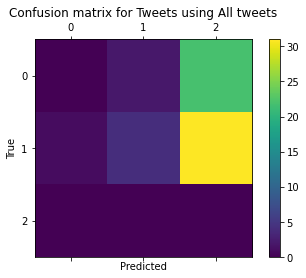

In [35]:
from sklearn.metrics import confusion_matrix

labels = ['0', '1', '2']
cm = confusion_matrix(df_questions_videos["binary_smarvote_answer"], df_questions_videos["cami_answer"])
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix for Tweets using All tweets')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

not very optimistic, transcription is not great
--> and then we translate
add more videos, create context vectors